Thie notebook explores logistic regression and feedforward neural networks for binary text classification for your text classification problem, using the pytorch library. 

In [1]:
from collections import Counter
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
import torch
import torch.nn as nn
import random
import pandas as pd
%matplotlib inline

In [2]:
def read_data(filename, max_data_points=None):
    X=[]
    Y=[]
    with open(filename, encoding="utf-8") as file:
        for idx,line in enumerate(file):
            cols=line.rstrip().split("\t")
            label=cols[0]
            text=cols[1]
            X.append(text)
            Y.append(label)

    # shuffle the data
    tmp = list(zip(X, Y))
    random.shuffle(tmp)
    X, Y = zip(*tmp)
    
    if max_data_points == None:
        return X, Y
    
    return X[:max_data_points], Y[:max_data_points]

In [6]:
# Change this to the directory with your data (from the CheckData_TODO.ipynb exercise).  
# The directory should contain train.tsv, dev.tsv and test.tsv
directory="../data/my_datasets/shortened"

We'll limit the training and dev data to 10,000 data points for this exercise.

In [7]:
trainX, trainY=read_data("%s/train.tsv" % directory, max_data_points=10000)

In [8]:
devX, devY=read_data("%s/dev.tsv" % directory, max_data_points=10000)

We'll represent the data using simple binary indicators of the most frequent 1000 words in the vocabulary.

In [9]:
vectorizer = CountVectorizer(max_features=1000, analyzer=str.split, lowercase=True, strip_accents=None, binary=True)
X_train = vectorizer.fit_transform(trainX)
X_dev = vectorizer.transform(devX)

_,vocabSize=X_train.shape

le = preprocessing.LabelEncoder()
le.fit(trainY)

Y_train=le.transform(trainY)
Y_dev=le.transform(devY)

In [10]:
def get_batches(x, y, batch_size=12):
    batches_x=[]
    batches_y=[]
    for i in range(0, len(x), batch_size):
        batches_x.append(x[i:i+batch_size])
        batches_y.append(y[i:i+batch_size])
    
    return batches_x, batches_y

In [11]:
train_batches_x, train_batches_y=get_batches(torch.from_numpy(X_train.todense()).float(), torch.LongTensor(Y_train))
dev_batches_x, dev_batches_y=get_batches(torch.from_numpy(X_dev.todense()).float(), torch.LongTensor(Y_dev))

In [12]:
def evaluate(model, x, y):

    model.eval()
    corr = 0.
    total = 0.
    with torch.no_grad():
        for x, y in zip(x, y):
            y_preds=model.forward(x)
            for idx, y_pred in enumerate(y_preds):
                prediction=torch.argmax(y_pred)
                if prediction == y[idx]:
                    corr += 1.
                total+=1                          
    return corr/total

In [13]:
class LogisticRegressionClassifier(nn.Module):

    def __init__(self, input_dim, output_dim):
        super().__init__()
        
        # torch.nn.Linear transforms an input of size input_dim (e.g., 1000 above) to an output of size output_dim (e.g., 2 classes for positive/negative)
        self.linear1 = torch.nn.Linear(input_dim, output_dim) 
    
    def forward(self, input): 
        x1 = self.linear1(input)

        return x1

In [14]:
class FFNN_1_Hidden_Layer(nn.Module):

    def __init__(self, input_dim, output_dim, hidden_dim=100):
        super().__init__()
        
        hidden_dim=100
        # the first layer transforms an input of size input_dim (e.g., 1000 above) to an output of size hidden_dim (e.g., 100)
        self.linear1 = torch.nn.Linear(input_dim, hidden_dim)

        # the second layer transforms an input of size hidden_dim (e.g., 100) to an output of size output_dim (e.g., 2 classes for positive/negative)       
        self.linear2 = torch.nn.Linear(hidden_dim, output_dim)
    
    def forward(self, input): 
        # pass the input through the first layer
        layer1_output = self.linear1(input)
        
        # pass that output through a non-linearity (here, tanh)
        layer1_output = torch.tanh(layer1_output)
        
        # and then pass the output from that first layer as input to the second layer
        layer2_output = self.linear2(layer1_output)

        return layer2_output

In [15]:
def train(model, model_filename, train_batches_x, train_batches_y, dev_batches_x, dev_batches_y):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    losses = []
    cross_entropy=nn.CrossEntropyLoss()

    best_dev_acc=0.
    
    # we'll only train for 5 epochs for this exercise, but in practice you'd want to train for more
    # (in general until you stop seeing improvements in accuracy on your *development* data)
    
    for epoch in range(5):
        model.train()

        for x, y in zip(train_batches_x, train_batches_y):
            y_pred=model.forward(x)
            loss = cross_entropy(y_pred.view(-1, 2), y.view(-1))
            losses.append(loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        dev_accuracy=evaluate(model, dev_batches_x, dev_batches_y)
        
        # we're going to save the model that performs the best on *dev* data
        if dev_accuracy > best_dev_acc:
            torch.save(model.state_dict(), model_filename)
            print("%.3f is better than %.3f, saving model ..." % (dev_accuracy, best_dev_acc))
            best_dev_acc = dev_accuracy
        if epoch % 1 == 0:
            print("Epoch %s, dev accuracy: %.3f" % (epoch, dev_accuracy))
            
    model.load_state_dict(torch.load(model_filename))            
    print("\nBest Performing Model achieves dev accuracy of : %.3f" % (best_dev_acc))
    return best_dev_acc
    

In [16]:
logreg=LogisticRegressionClassifier(1000, 2)
dev_accuracy=train(logreg, "logreg.model", train_batches_x, train_batches_y, dev_batches_x, dev_batches_y)

0.467 is better than 0.000, saving model ...
Epoch 0, dev accuracy: 0.467
0.483 is better than 0.467, saving model ...
Epoch 1, dev accuracy: 0.483
Epoch 2, dev accuracy: 0.483
Epoch 3, dev accuracy: 0.467
Epoch 4, dev accuracy: 0.467

Best Performing Model achieves dev accuracy of : 0.483


In [17]:
ffnn1=FFNN_1_Hidden_Layer(1000, 2, hidden_dim=100)
dev_accuracy=train(ffnn1, "ffnn1.model", train_batches_x, train_batches_y, dev_batches_x, dev_batches_y)

0.467 is better than 0.000, saving model ...
Epoch 0, dev accuracy: 0.467
0.500 is better than 0.467, saving model ...
Epoch 1, dev accuracy: 0.500
Epoch 2, dev accuracy: 0.500
Epoch 3, dev accuracy: 0.450
Epoch 4, dev accuracy: 0.450

Best Performing Model achieves dev accuracy of : 0.500


Neural networks converge to different solutions as a function of their *initialization* (the random choice of the initial values for parameters).  Let's train the `FFNN_1_Hidden_Layer` model 10 times and then plot the distribution of dev accuracies using [pandas.DataFrame.plot.density](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.density.html). 

In [18]:
dev_accuracies=[]

for i in range(10):
    ffnn1=FFNN_1_Hidden_Layer(1000, 2, hidden_dim=100)
    dev_accuracy=train(ffnn1, "ffnn1.model", train_batches_x, train_batches_y, dev_batches_x, dev_batches_y)
    dev_accuracies.append(dev_accuracy)

0.450 is better than 0.000, saving model ...
Epoch 0, dev accuracy: 0.450
0.467 is better than 0.450, saving model ...
Epoch 1, dev accuracy: 0.467
Epoch 2, dev accuracy: 0.467
Epoch 3, dev accuracy: 0.417
Epoch 4, dev accuracy: 0.450

Best Performing Model achieves dev accuracy of : 0.467
0.500 is better than 0.000, saving model ...
Epoch 0, dev accuracy: 0.500
0.533 is better than 0.500, saving model ...
Epoch 1, dev accuracy: 0.533
Epoch 2, dev accuracy: 0.500
Epoch 3, dev accuracy: 0.450
Epoch 4, dev accuracy: 0.500

Best Performing Model achieves dev accuracy of : 0.533
0.483 is better than 0.000, saving model ...
Epoch 0, dev accuracy: 0.483
Epoch 1, dev accuracy: 0.467
0.500 is better than 0.483, saving model ...
Epoch 2, dev accuracy: 0.500
Epoch 3, dev accuracy: 0.417
Epoch 4, dev accuracy: 0.450

Best Performing Model achieves dev accuracy of : 0.500
0.450 is better than 0.000, saving model ...
Epoch 0, dev accuracy: 0.450
0.483 is better than 0.450, saving model ...
Epoch 1,

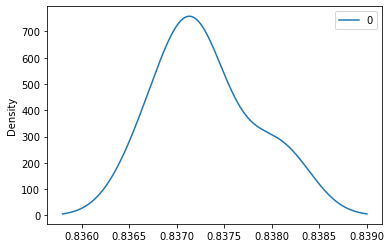

In [20]:
df=pd.DataFrame(dev_accuracies)
ax = df.plot.kde()

Try adding more layers to the FFNN below and experimenting with the dropout rate, hidden layer sizes, and different choices of non-linearity.

In [17]:
class FFNN_Experiment(nn.Module):

    def __init__(self, input_dim, output_dim, hidden_dim=100):
        super().__init__()

        hidden_dim=100
        
        # the first layer transforms an input of size input_dim (e.g., 1000 above) to an output of size hidden_dim (e.g., 100)
        self.linear1 = torch.nn.Linear(input_dim, hidden_dim)

        # a dropout layer randomly sets the output from the previous layer to 0 p% of the time
        self.dropout = nn.Dropout(p=0.2)

        # the second layer transforms an input of size hidden_dim (e.g., 100) to an output of size output_dim (e.g., 2 classes for positive/negative)       
        self.linear2 = torch.nn.Linear(hidden_dim, output_dim)
    
    def forward(self, input): 
        # pass the input through the first layer
        layer1_output = self.linear1(input)
        
        # pass that output through a non-linearity (here, tanh)
        # alternatives include torch.relu and torch.sigmoid
        layer1_output = torch.tanh(layer1_output)
        
        # then dropout some outputs during training time (not test time)
        layer1_output=self.dropout(layer1_output)
        
        # and then pass the output from that first layer as input to the second layer
        layer2_output = self.linear2(layer1_output)

        return layer2_output

In [18]:
ffnn_e=FFNN_Experiment(1000, 2, hidden_dim=100)
dev_accuracy=train(ffnn_e, "ffnn_e.model", train_batches_x, train_batches_y, dev_batches_x, dev_batches_y)

0.835 is better than 0.000, saving model ...
Epoch 0, dev accuracy: 0.835
Epoch 1, dev accuracy: 0.834
Epoch 2, dev accuracy: 0.832
Epoch 3, dev accuracy: 0.832
Epoch 4, dev accuracy: 0.832

Best Performing Model achieves dev accuracy of : 0.835


In [ ]:
class CNNClassifier_unigram_bigram(nn.Module):

    """
    CNN over window sizes of 1 (unigrams) and 2 (bigrams) each 96 filters, where a document
    is representated as the concatentation of the 96 ungram filters + 96 bigram filters.
    
    """
        
    def __init__(self, pretrained_embeddings):
        super().__init__()
        
        self.num_filters=96
        
        self.num_labels = 2

        _, embedding_dim=pretrained_embeddings.shape
        
        self.embeddings = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)

        # convolution over 1 word
        self.conv_1 = nn.Conv1d(embedding_dim, self.num_filters, 1, 1)

        # convolution over 2 words    
        self.conv_2 = nn.Conv1d(embedding_dim, self.num_filters, 2, 1)

        self.fc = nn.Linear(self.num_filters*2, self.num_labels)

    
    def forward(self, input): 
        
        # batch_size x max_seq_length x embeddings_size
        x0 = self.embeddings(input)
        
        # batch_size x embeddings_size x max_seq_length
        # (the input order expected by nn.Conv1d)
        x0 = x0.permute(0, 2, 1)

        # convolution
        x1 = self.conv_1(x0)
        # non-linearity
        x1 = torch.tanh(x1)
        # global max-pooling over the entire sequence
        x1=torch.max(x1, 2)[0]

        x2 = self.conv_2(x0)
        x2 = torch.tanh(x2)
        x2=torch.max(x2, 2)[0]

        combined=torch.cat([x1, x2], dim=1)

        out = self.fc(combined)
        
        return out        